# 累積カーブをダミーで生成してシグモイド関数でfittingする

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cmdstanpy

## ダミーデータの作成

# dummy dataを生成する

In [2]:
import numpy as np
import pandas as pd

def _build_irregular_anchors(x_min, x_max, mean_step, step_std, min_step, max_step, rng):
    xs = [x_min]
    while xs[-1] < x_max:
        step = int(np.round(rng.normal(mean_step, step_std)))
        step = int(np.clip(step, min_step, max_step))
        nxt = xs[-1] + step
        if nxt >= x_max:
            xs.append(x_max)
            break
        xs.append(nxt)
    return np.array(xs, dtype=int)

def _sigmoid_params_from_psat(x0, p_sat, eps):
    """
    y = 10 / (1 + exp(-k*(x - x0))) として、
    x = p_sat で y = 10*(1 - eps) になるように k を決める。
    """
    # Δ = p_sat - x0 (>0を想定)
    delta = float(p_sat - x0)
    if delta <= 0:
        delta = 1.0  # 念のためのガード
    k = (1.0 / delta) * np.log((1.0 - eps) / eps)
    return k

def _sigmoid_scaled(x, x0, k):
    s = 1.0 / (1.0 + np.exp(-k * (x - x0)))
    return 10.0 * s  # [0,10] にスケール

def hour_to_psat(
    hour: int,
    low: int = 1500,
    high: int = 2000,
    phase_shift_hours: float = 6.0,
) -> float:
    """
    時刻(hour)→ p_sat（yが10にほぼ達する価格）を周期(24h)で決める。
    sin波で [low, high] に写像。phase_shift_hours で位相を調整。
    """
    mid = 0.5 * (low + high)
    amp = 0.5 * (high - low)
    # 0..23 を 0..2π に変換し位相をずらす（朝方高くしたい等の調整に）
    theta = 2.0 * np.pi * ((hour - phase_shift_hours) % 24) / 24.0
    return mid + amp * np.sin(theta)

def make_sigmoid_like_dataset_for_hour(
    hour: int,
    x_min: int = 0,
    x_max: int = 2000,
    mean_step: int = 20,
    step_std: int = 7,
    min_step: int = 5,
    max_step: int = 35,
    x0: float = 1000.0,      # シグモイド中心（固定）
    eps: float = 1e-3,       # p_satで"ほぼ"10(=10*(1-eps))に到達
    noise_sd_low: float = 0.02,
    noise_sd_mid: float = 0.08,
    phase_shift_hours: float = 6.0,  # 周期の山/谷の時刻調整
    p_sat_low: int = 1500,
    p_sat_high: int = 2000,
    seed: int = None,
    save_csv_path: str | None = None,
) -> pd.DataFrame:
    """
    指定時刻(hour)の累積入札量ダミーデータを作成。
    - yは[0,10]にクリップ、単調増加（非減少）を保証
    - アンカー間はギャップごとに ffill/bfill をランダム適用
    返り値: DataFrame[x, y, is_anchor, fill_method, hour, p_sat]
    """
    rng = np.random.default_rng(seed)

    # --- 時刻に応じた p_sat を決定（1500〜2000） ---
    p_sat = hour_to_psat(hour, low=p_sat_low, high=p_sat_high, phase_shift_hours=phase_shift_hours)

    # --- その p_sat で 10*(1-eps) に達するように傾き k を決める ---
    k = _sigmoid_params_from_psat(x0=x0, p_sat=p_sat, eps=eps)

    # --- 不均一アンカー x ---
    anchors_x = _build_irregular_anchors(x_min, x_max, mean_step, step_std, min_step, max_step, rng)

    # --- アンカー y（軽いノイズ; 中央でやや大きく） ---
    base_y = _sigmoid_scaled(anchors_x, x0=x0, k=k)
    mid_weight = 1.0 - np.abs((anchors_x - x0) / (x0 - x_min))  # 端0, 中央1（x_min<x0想定）
    noise_sd = noise_sd_low + (noise_sd_mid - noise_sd_low) * np.clip(mid_weight, 0, 1)
    noisy = base_y + rng.normal(0.0, noise_sd)
    noisy = np.clip(noisy, 0.0, 10.0)

    # --- 単調増加（非減少）保証：累積最大 ---
    anchors_y = np.maximum.accumulate(noisy)
    anchors_y = np.clip(anchors_y, 0.0, 10.0)

    # --- 全xに拡張し、各ギャップで ffill/bfill をランダム適用 ---
    full_x = np.arange(x_min, x_max + 1, dtype=int)
    y = np.full(full_x.shape, np.nan, dtype=float)

    anchor_mask = np.zeros_like(full_x, dtype=bool)
    anchor_idx = np.searchsorted(full_x, anchors_x)
    anchor_mask[anchor_idx] = True
    y[anchor_idx] = anchors_y

    fill_method = np.full(full_x.shape, "", dtype=object)
    for i in range(len(anchor_idx) - 1):
        s, e = anchor_idx[i], anchor_idx[i + 1]
        method = rng.choice(["ffill", "bfill"])
        if method == "ffill":
            y[s + 1 : e] = y[s]
            fill_method[s + 1 : e] = "ffill"
        else:
            y[s + 1 : e] = y[e]
            fill_method[s + 1 : e] = "bfill"

    # クリップ＆最終単調性担保
    y = np.clip(y, 0.0, 10.0)
    if not np.all(np.diff(y) >= -1e-12):
        y = np.maximum.accumulate(y)

    df = pd.DataFrame(
        {
            "x": full_x,
            "y": y,
            "is_anchor": anchor_mask,
            "fill_method": fill_method,
            "hour": hour,
            "p_sat": p_sat,  # その時刻で 10 にほぼ到達する価格
        }
    )

    if save_csv_path:
        df.to_csv(save_csv_path, index=False)

    return df

def make_all_hours_dataset(
    **kwargs
) -> pd.DataFrame:
    """
    0〜23時すべてのデータを縦結合して返す。
    kwargs は make_sigmoid_like_dataset_for_hour にそのまま渡される。
    """
    frames = [make_sigmoid_like_dataset_for_hour(hour=h, **kwargs) for h in range(24)]
    return pd.concat(frames, ignore_index=True)

# # --- 使い方例 ---
# if __name__ == "__main__":
#     # 例: 7時のシリーズを作成して保存
#     df7 = make_sigmoid_like_dataset_for_hour(
#         hour=7,
#         save_csv_path="bids_hour07.csv",
#         seed=123
#     )
#     print(df7.head(), df7.tail())

#     # 例: 24時間ぶんを作って確認
#     df_all = make_all_hours_dataset(seed=123)
#     print(df_all.groupby("hour")["p_sat"].agg(["min","max","mean"]))

In [5]:
dflist = []
for date in pd.date_range("2022-01-01", "2022-01-30", freq="D"):
    df_all = make_all_hours_dataset()
    df_all["date"] = date
    dflist.append(df_all)
dfout = pd.concat(dflist)

In [6]:
dfout[["date","x","y","hour",]].to_parquet("../customdataset/accum_curve_dataset.parquet",compression="lz4")

In [4]:
dfout = df_all.pivot_table(index="x", columns="hour", values="y")

In [99]:
df_all

,x,y,is_anchor,fill_method,hour,p_sat
0,0,0.0,True,,0,1500.000000
1,1,0.0,False,ffill,0,1500.000000
2,2,0.0,False,ffill,0,1500.000000
3,3,0.0,False,ffill,0,1500.000000
4,4,0.0,False,ffill,0,1500.000000
...,...,...,...,...,...,...
48019,1996,10.0,False,ffill,23,1508.518543
48020,1997,10.0,False,ffill,23,1508.518543
48021,1998,10.0,False,ffill,23,1508.518543
48022,1999,10.0,True,,23,1508.518543


In [108]:
dfout[["date","x","y","hour",]].to_csv("../customdataset/accum_curve_dataset.csv.gz",compression="gzip")

(0.0, 2000.0)

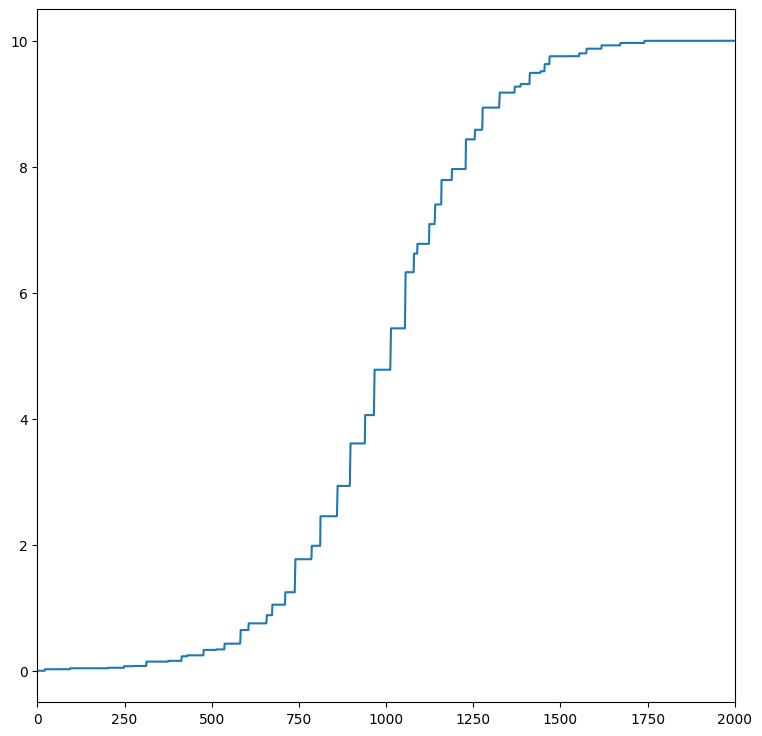

In [81]:
fig,ax = plt.subplots(figsize=(6,6))
ax.plot(df["x"], df["y"])
ax.set_xlim(0,2000)

(0.0, 2000.0)

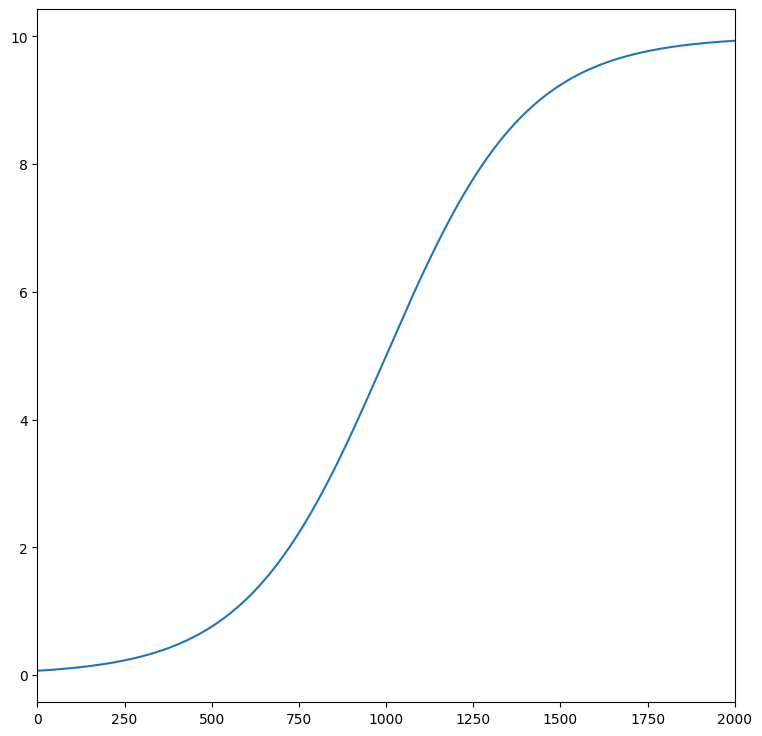

In [34]:
fig,ax = plt.subplots(figsize=(9,9))
ax.plot(x,y)
ax.set_xlim(0,2000)

